In [327]:
using CSV, DataFrames, Statistics, Random, Plots, JuMP, Gurobi, Distributions, Random, Metrics
using StatsBase: sample
include("utils.jl");

In [328]:
using ScikitLearn
@sk_import linear_model: LogisticRegression
@sk_import linear_model: Lasso
# @sk_import metrics:accuracy_score;
# @sk_import metrics:precision_score;
# @sk_import metrics:recall_score;

PyObject <class 'sklearn.linear_model._coordinate_descent.Lasso'>

In [329]:
function get_weights2(X_train, X_test, print_results = false)
    X_combined = vcat(X_train, X_test)
    y_combined = vcat(zeros(size(X_train)[1]),ones(size(X_test)[1]))

    lr = fit!(LogisticRegression(max_iter = 2000, random_state = 1, fit_intercept = false), Matrix(X_combined), y_combined)
    if print_results
        y_pred_combined = lr.predict(Matrix(X_combined))
        check_accuracy(y_pred_combined, y_combined)
    end
    y_pred_combined_prob = lr.predict_proba(Matrix(X_train))

    weights_shift = y_pred_combined_prob[:, 2] ./ y_pred_combined_prob[:, 1]
    return weights_shift
end

get_weights2 (generic function with 2 methods)

In [330]:
struct CovariateShift
    name::String
    X_full::DataFrame
    X_shifted::DataFrame
    y_full::Vector{Float64}
    y_shifted::Vector{Float64}
    covar_dist_type::String
    covar_parameters::Vector{Any}
    lambas_range::Vector{Float64}
    train_test_prop::Float64
    train_val_prop::Float64
    num_runs::Float64
end


In [331]:
function perform_covariate_shift(rc::CovariateShift, X_full_norm)
    pca_result = perform_pca(X_full_norm)
    m = median(pca_result)
    X_train, X_test = [], []
    y_train, y_test = [], []

    for i in 1:size(X_full_norm, 1)
        if pca_result[i, 1] >= m
            if rand() <= rc.covar_parameters[1]
                push!(X_train, X_full_norm[i, :])
                push!(y_train, rc.y_full[i])
            else
                push!(X_test, X_full_norm[i, :])
                push!(y_test, rc.y_full[i])
            end
        end
        
        if pca_result[i, 1] < m
            if rand() <= rc.covar_parameters[2]
                push!(X_train, X_full_norm[i, :])
                push!(y_train, rc.y_full[i])
            else
                push!(X_test, X_full_norm[i, :])
                push!(y_test, rc.y_full[i])
            end
        end
    end
    
    # reshape list of lists to be a matrix
    X_train_reshaped = zeros(length(X_train), size(X_full_norm, 2))
    X_test_reshaped = zeros(length(X_test), size(X_full_norm, 2))
    
    for i in 1:size(X_train, 1)
        X_train_reshaped[i, :] = X_train[i]
    end
    for i in 1:size(X_test, 1)
        X_test_reshaped[i, :] = X_test[i]
    end
    
    idx_train = randperm(size(X_train, 1))[1:Int(rc.covar_parameters[3])]
    idx_test = randperm(size(X_test, 1))[1:Int(rc.covar_parameters[4])]
    X_train_reshaped = X_train_reshaped[idx_train, :]
    X_test_reshaped = X_test_reshaped[idx_test, :]
    y_train = y_train[idx_train]
    y_test = y_test[idx_test]
    
    return (X_train_reshaped, y_train), (X_test_reshaped, y_test)
end


perform_covariate_shift (generic function with 1 method)

In [332]:
function normalise_X_full(rc::CovariateShift)
    mean_vals = mean(Matrix(rc.X_full), dims=1)
    std_vals = std(Matrix(rc.X_full), dims=1)
    X_full_norm = (Matrix(rc.X_full) .-mean_vals) ./ std_vals;
    return X_full_norm 
    
end

function train_test_split(rc::CovariateShift, random_seed)
    
    Random.seed!(random_seed)

    num_indices = round(Int, rc.train_test_prop * length(rc.y_full))
    train_indices = sample(1:length(rc.y_full), num_indices, replace=false)
    test_indices = setdiff(1:length(rc.y_full), train_indices)
    
    X_train, y_train = Matrix(rc.X_full)[train_indices, :], rc.y_full[train_indices]
    X_test, y_test = Matrix(rc.X_shifted)[test_indices, :], rc.y_shifted[test_indices]
    
    return (X_train, y_train), (X_test, y_test)
end



function train_val_split(rc::CovariateShift, X_full_train, y_full_train, weights = "nothing", random_seed = 1)
    
    Random.seed!(random_seed)

    num_indices = round(Int, rc.train_val_prop * length(y_full_train))
    train_indices = sample(1:length(y_full_train), num_indices, replace=false)
    val_indices = setdiff(1:length(y_full_train), train_indices)
    
    X_train, y_train = Matrix(X_full_train)[train_indices, :],y_full_train[train_indices]
    X_val, y_val = Matrix(X_full_train)[val_indices, :], y_full_train[val_indices]

    if weights !== "nothing"
        weights = weights[train_indices]
    end
    
    return (X_train, y_train, weights), (X_val, y_val)
end

train_val_split (generic function with 3 methods)

In [333]:


function get_random_test_score(rc::CovariateShift, X_full_train, y_full_train, X_test, y_test, seed_value, weights="nothing", print_result=false)
    best_lambda = Inf
    best_val_mse = Inf
    best_model = Inf

    (X_train, y_train, weights_for_train), (X_val, y_val) = train_val_split(rc, X_full_train, y_full_train, weights, seed_value)
    
    if weights !== "nothing"
        println("length: ", length(weights_for_train))
        println("length y: ", length(y_train))
    end
    for lambda in rc.lambas_range
        
        beta_star = LassoRegression(X_train, y_train, lambda, weights_for_train)
        y_pred_val = X_val * beta_star
        val_mse_i = mse(y_val, y_pred_val)
     
        # lr = Lasso(alpha = lambda, fit_intercept = false).fit(X_train, y_train, weights)
        # lr = fit!(lr, X_train, y_train, weights)
        # y_pred_val= lr.predict(X_val)

        if best_val_mse > val_mse_i
            best_lambda = lambda
            best_val_mse = val_mse_i
            best_model = beta_star
        end
    end

    #get test mse score on best performing mo
    y_pred_test = X_test * best_model
    mse_test_mse = mse(y_test, y_pred_test)
    if print_result
        println("Best lambda: ", best_lambda)
        println("Validation score: ", best_val_mse)
        println("Test score: ", mse_test_mse)
        println("Number of betas: ", length(best_model))
    end
    return best_model, mse_test_mse
end

#todo: deal with prints (false)
#todo: add what is returned to instance 
function repeat_four_methods(rc::CovariateShift)

    random_mse_test_scores, random_weights_mse_test_scores = [], []

    rand_betas, rand_weights_betas = [], []

    for random_seed in 1:rc.num_runs
        random_seed = Int(random_seed) #need to be int 

        if rc.covar_dist_type == "PCA"
            #pca shift on real dataset 
            X_full_norm = normalise_X_full(rc)
            (X_train, y_train), (X_test, y_test) = perform_covariate_shift(rc, X_full_norm)
        else
            # synthetic data (shift has already been performed when creating the dataset)
            (X_train, y_train), (X_test, y_test) = train_test_split(rc, random_seed)
        end

        X_train_norm, X_test_norm = normalize_data(X_train, X_test)
        X_train_norm_intercept, X_test_norm_intercept = add_intercept(X_train_norm), add_intercept(X_test_norm)

        weights = get_weights2(X_train_norm_intercept, X_test_norm_intercept, true)

        if random_seed % 10 == 0
            println(random_seed)
        end

        rand_beta, random_mse_test_score = get_random_test_score(rc, X_train_norm_intercept, y_train, X_test_norm_intercept, y_test, random_seed, "nothing", false)
        push!(random_mse_test_scores, random_mse_test_score)
        push!(rand_betas, rand_beta)

        rand_weights_beta, random_weights_mse_test_score = get_random_test_score(rc, X_train_norm_intercept, y_train, X_test_norm_intercept, y_test, random_seed, weights, false)
        push!(random_weights_mse_test_scores, random_weights_mse_test_score)
        push!(rand_weights_betas, rand_weights_beta)
    end 
    
    return (rand_betas, rand_weights_betas), (random_mse_test_scores, random_weights_mse_test_scores)
end

repeat_four_methods (generic function with 1 method)

In [334]:
#hyperparameters
num_runs = 100
train_test_prop = 0.9
train_val_prop = 0.7
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1];


### Synthetic data 1

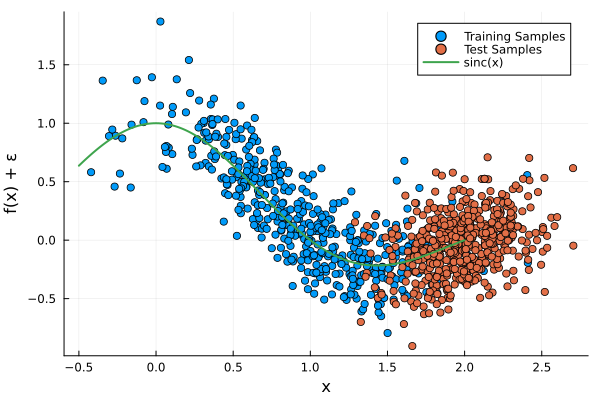

In [336]:
(X_full, y_full), (X_shifted, y_shifted) = generate_synthetic_data(500, "1", 123);

synthetic_instance_1 = CovariateShift(
    "synthetic_1",
    X_full,
    X_shifted,
    y_full,
    y_shifted,
    "Synthetic",
    [],
    lambdas,
    train_test_prop,
    train_val_prop,
    num_runs);

plot_synthetic(X_full, y_full, X_shifted, y_shifted, "1")

In [337]:
(rand_betas, rand_weights_betas), (random_mse_test_scores, random_weights_mse_test_scores) = repeat_four_methods(synthetic_instance_1);
betas_rand = mean(rand_betas, dims = 1)
betas_weight_random = mean(rand_weights_betas, dims =1)

accuracy: 0.922
precision: 0.641025641
recall: 0.5
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.9

1-element Vector{Vector{Float64}}:
 [-0.22606915589484392, 0.10514611767617195]

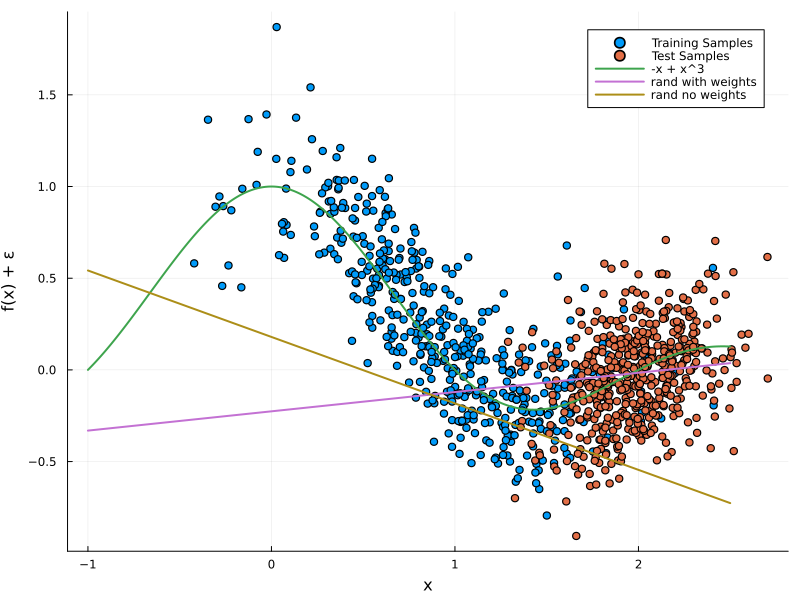

In [338]:
f_1(x) = sinc(x)
# f_ow(x) =  mean_opt_weights_betas[1][1] +  mean_opt_weights_betas[1][2]* x
f_r(x) =  betas_rand[1][1] +  betas_rand[1][2]* x
f_rw(x) =  betas_weight_random[1][1] +  betas_weight_random[1][2]* x
# f_o(x) =  mean_opt_betas[1][1] +  mean_opt_betas[1][2]* x

plot_obj = scatter(Matrix(X_full), y_full, label="Training Samples", xlabel="x", ylabel="f(x) + ε")
scatter!(Matrix(X_shifted), y_shifted, label="Test Samples")

x_values = range(-1, stop=2.5, length=500)

# Modify the size attribute to make the plot bigger
plot!(x_values, f_1.(x_values), label="-x + x^3", linewidth=2, size=(800, 600))
# plot!(x_values, f_ow.(x_values), label="opt with weights", linewidth=2, size=(800, 600))
plot!(x_values, f_rw.(x_values), label="rand with weights", linewidth=2, size=(800, 600))
plot!(x_values, f_r.(x_values), label="rand no weights", linewidth=2, size=(800, 600))
# plot!(x_values, f_o.(x_values), label="opt no weights", linewidth=2, size=(800, 600))

# savefig(plot_obj, "../data/imgs/covariate_shift_synthetic_data_2.png")

display(plot_obj)

In [339]:
print(mean((random_mse_test_scores .- random_weights_mse_test_scores) ./random_mse_test_scores * 100))


81.60918432634665

## synthetic 2

In [341]:
(X_full, y_full), (X_shifted, y_shifted) = generate_synthetic_data(500, "2", 123);

synthetic_instance_2 = CovariateShift(
    "synthetic_2",
    X_full,
    X_shifted,
    y_full,
    y_shifted,
    "Synthetic",
    [],
    lambdas,
    train_test_prop,
    train_val_prop,
    num_runs);

In [342]:
(rand_betas, rand_weights_betas), (random_mse_test_scores, random_weights_mse_test_scores) = repeat_four_methods(synthetic_instance_2);
betas_rand = mean(rand_betas, dims = 1)
betas_weight_random = mean(rand_weights_betas, dims =1)

accuracy: 0.892
precision: 0.0
recall: 0.0
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.9
precisi

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.9
precision: 0.0
recall: 0.0
Set parameter Username


/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.89
precision: 0.2222222222
recall: 0.04
Set paramete

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.894
precision: 0.3636363636
recall: 0.08
Set paramet

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.888
precision: 0.0
recall: 0.0
Set parameter Usernam

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.898
precision: 0.0
recall: 0.0
Set parameter Usernam

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.892
precision: 0.0
recall: 0.0
Set parameter Usernam

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.886
precision: 0.1111111111
recall: 0.02
Set paramet

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.892
precision: 0.25
recall: 0.04
Set parameter Usern

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.896
precision: 0.25
recall: 0.02
Set parameter Usern

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.896
precision: 0.0
recall: 0.0
Set parameter Usernam

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.896
precision: 0.375
recall: 0.06
Set parameter User

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.886
precision: 0.0
recall: 0.0
Set parameter Usernam

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.886
precision: 0.0
recall: 0.0
Set parameter Usernam

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.9
precision: 0.0
recall: 0.0
Set parameter Username


/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.894
precision: 0.3333333333
recall: 0.06
Set paramet

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.888
precision: 0.125
recall: 0.02
Set parameter User

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.898
precision: 0.0
recall: 0.0
Set parameter Usernam

/Users/norahallqvist/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 315
length y: 315
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.89
precision: 0.2222222222
recall: 0.04
Set paramete

1-element Vector{Vector{Float64}}:
 [-0.17176031414090828, -0.205794762631804]

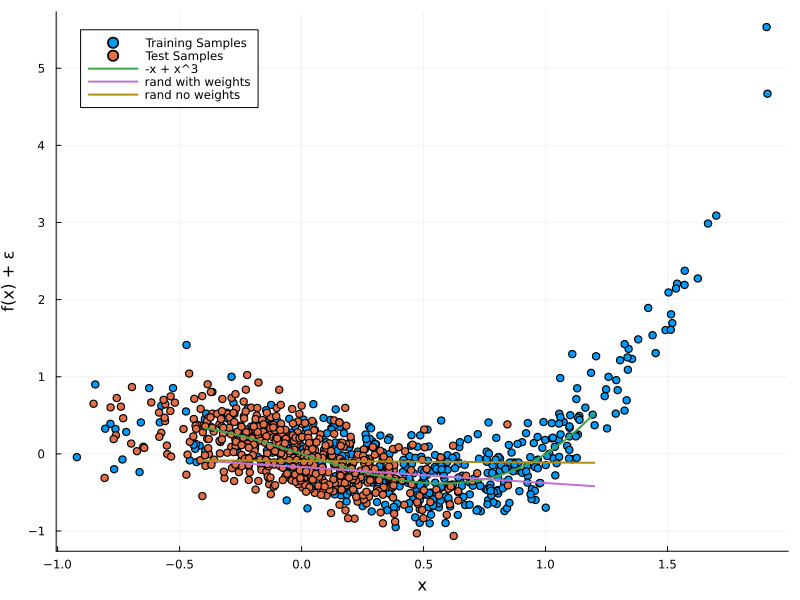

In [345]:
f_2(x) = -x + x^3 
# f_ow(x) =  mean_opt_weights_betas[1][1] +  mean_opt_weights_betas[1][2]* x
f_r(x) =  betas_rand[1][1] +  betas_rand[1][2]* x
f_rw(x) =  betas_weight_random[1][1] +  betas_weight_random[1][2]* x
# f_o(x) =  mean_opt_betas[1][1] +  mean_opt_betas[1][2]* x

plot_obj = scatter(Matrix(X_full), y_full, label="Training Samples", xlabel="x", ylabel="f(x) + ε")
scatter!(Matrix(X_shifted), y_shifted, label="Test Samples")

x_values = range(-0.4, stop=1.2, length=500)

# Modify the size attribute to make the plot bigger
plot!(x_values, f_2.(x_values), label="-x + x^3", linewidth=2, size=(800, 600))
# plot!(x_values, f_ow.(x_values), label="opt with weights", linewidth=2, size=(800, 600))
plot!(x_values, f_rw.(x_values), label="rand with weights", linewidth=2, size=(800, 600))
plot!(x_values, f_r.(x_values), label="rand no weights", linewidth=2, size=(800, 600))
# plot!(x_values, f_o.(x_values), label="opt no weights", linewidth=2, size=(800, 600))

# savefig(plot_obj, "../data/imgs/covariate_shift_synthetic_data_2.png")

display(plot_obj)

In [346]:
print(mean((random_mse_test_scores .- random_weights_mse_test_scores) ./random_mse_test_scores * 100))


28.06948762896958

## concrete data

In [287]:
X_full_df, y_full = get_concrete_data()

concrete_instance = CovariateShift(
    "concrete",
    X_full_df,
    X_full_df,
    y_full,
    y_full,
    "PCA",
    [0.1,0.9, 405, 45],
    lambdas,
    train_test_prop,
    train_val_prop,
    100);

    

In [288]:
concrete_instance.lambas_range

5-element Vector{Float64}:
 1.0e-5
 0.0001
 0.001
 0.01
 0.1

In [289]:
(rand_betas, rand_weights_betas), (random_mse_test_scores, random_weights_mse_test_scores) = repeat_four_methods(concrete_instance);

accuracy: 0.9
precision: 0.5
recall: 0.2
[0.0, 1.0]
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
length: 284
length y: 284
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-11
accuracy: 0.

In [281]:
print(mean((random_mse_test_scores .- random_weights_mse_test_scores) ./random_mse_test_scores * 100))


49.70813925271727